In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
# standard imports (we almost always use)

import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')
#
# let's take a chance on geopy. sometimes, geopy can break, since it (at lest for some components)
# requires web connectivity for location service functionality. i think we'll only use the great_circle()
# distance measurmenet, so if it comes to it, we can replace this with a hard-coded spherical distance
# solution.
import geopy
import geopy.distance as gdp
#
import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
import itertools
import sys
import sklearn
from sklearn import cluster as skcp
#import scipy.optimize as spo
import os
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import functools
#
# let's see if we can compile some of thes functions.
import numba
#
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
import data_type_wranglers as dtw
#
#
# so eventually, i need to streamline my understanding of the new matplotlib colors,etc. iterator, but for now
# let's just hard-type the old colors into a list...
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
#
data_file = 'zika_data/zika_latitude_longitude.tsv'
delim = chr(9)

#### Tab vs Space delimiting...
- So which is it, tabs or spaces?
- I'll put it on the table. I'm a tabs guy; we can rescale them, as we please, in our editor of choice, one character vs n-characters, etc.
- ... and yet I know that this appears to be an unpopular position, but I'm going to stick to it.
- ... most of the time anyway. If I'm prototyping code to port to an external module, I'll typically use tab delimitation. For pure notebook-work, I'll just as often use spaces.


In [3]:
%%javascript
    // also, turns out this method of tab/space delimiter definitino is a bit twitchy. there
    // are some other ways to do this, i think...
    //
    // apply setting to all current CodeMirror instances
    IPython.notebook.get_cells().map(
        
        //function(c) {  return c.code_mirror.options.indentWithTabs=true;
        function(c) {  return c.code_mirror.options.indentWithTabs=false;}
    );

    // make sure new CodeMirror instances created in the future also use this setting
    //CodeMirror.defaults.indentWithTabs=true;
    CodeMirror.defaults.indentWithTabs=true;

<IPython.core.display.Javascript object>

In [4]:
# open the data file; get column headers and data. lots of options for data containers; we'll try to
# talk about some options.
# sometimes we like to use a little "type_guesser()" function; we can use this to construct recarrays,
# or we can use PANDAS, but for the time being, let's keep it simple and use a dict{}. the main problem
# with the dict{}, compared to a recarray or PANDAS dataframe is that it is unstable -- the records
# can be sorted independently, and so decorrelated. if we want to get nutty, we could write a 
# super_dict(dict) subclass with a sort() function... which we would write.
#
# nominally, we need to verify the integrity of the data -- are there delimiters missing, data missing,
# etc. we can do this (sort of) by using a recarray -- it will break if there is a type error.
# we might also modify type_guesser() to return the type function, rather than the re-cast value,
# and then verify that all elements in a column are the same type. but for now, i'm going to assume that
# we can forego these exercises (unless something comes up that requires it...)
#
# so let's have a quick look...
with open(data_file, 'r') as fin:
    col_names = fin.readline().split(delim)
    print('col_names: {}'.format(col_names))
    #
    for j,rw in enumerate(fin):
        #first_rw = fin.readline()[:-1].split(delim)
        rws = rw[:-1].split(delim)
        print('rw: {}'.format(rws))
        types = [dtw.guess_type(s) for s in rws]
        print('guessed_types: ', types)
        if j>=5: break
#
with open(data_file, 'r') as fin:
    #col_names = fin.readline().split(delim)
    zika_data = {cl:[] for cl in fin.readline()[:-1].split(delim)}
    #
    for j,rw in enumerate(fin):
        # consider excluding rows that do not contain the work 'zika' (explicitly):
        #if not 'zika' in rw.lower(): continue
        rws = rw[:-1].split(delim)
        for key,val in zip(zika_data.keys(), rws): zika_data[key]+=[dtw.guess_type(val)]
        #
    # 
#
# for some purposes, it might be beneficial to transform these to a 0 < lon < 360 longitude domain,
#   from -180<lon<180
#for j,z in enumerate(zika_data['longitude']): zika_data['longitude'][j]+=180.


col_names: ['latitude', 'longitude', 'title', 'date', 'topic\n']
rw: ['25.77427', '-80.19366', 'Fêting Leo DiCaprio’s climate change doc in Miami', '2016-10-06', 'Hurricane Matthew & Standing Water']
guessed_types:  [25.77427, -80.19366, 'Fêting Leo DiCaprio’s climate change doc in Miami', datetime.datetime(2016, 10, 6, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f65dfec0048>), 'Hurricane Matthew & Standing Water']
rw: ['25.77427', '-80.19366', 'With $1.1 billion in new funding, U.S. health officials outline plan for fighting Zika', '2016-10-03', 'Money & Vaccine Trial']
guessed_types:  [25.77427, -80.19366, 'With $1.1 billion in new funding, U.S. health officials outline plan for fighting Zika', datetime.datetime(2016, 10, 3, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f65dfec0048>), 'Money & Vaccine Trial']
rw: ['25.77427', '-80.19366', 'Congress approves $1.1 billion in Zika funding', '2016-09-28', 'Planned Parenthood & Senate Republicans']
guessed_types:  [25.77427, -80.1

In [5]:
# have a quick look...
for key,vals in zika_data.items():
    print('[{}]: {}'.format(key, vals[0:5]))

[latitude]: [25.77427, 25.77427, 25.77427, 25.77427, 25.77427]
[longitude]: [-80.19366, -80.19366, -80.19366, -80.19366, -80.19366]
[title]: ['Fêting Leo DiCaprio’s climate change doc in Miami', 'With $1.1 billion in new funding, U.S. health officials outline plan for fighting Zika', 'Congress approves $1.1 billion in Zika funding', "Bats, of course. A Miami Beach official's proposal to combat Zika-carrying mosquitoes", 'Zika mosquito sites in Miami Beach identified']
[date]: [datetime.datetime(2016, 10, 6, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f65dfec0048>), datetime.datetime(2016, 10, 3, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f65dfec0048>), datetime.datetime(2016, 9, 28, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f65dfec0048>), datetime.datetime(2016, 10, 18, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f65dfec0048>), datetime.datetime(2016, 9, 27, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7f65dfec0048>)]
[topic]: ['Hurricane Matthew & Standing Wa

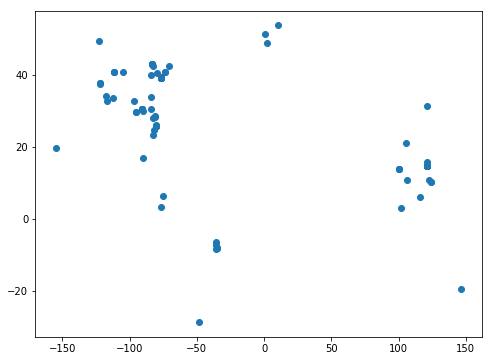

In [6]:
# now, plot it. first, just plot it; then we'll do a map.
#
plt.figure(figsize=(8,6))
plt.clf()
ax = plt.subplot('111')
#
plt.scatter(zika_data['longitude'], zika_data['latitude'], marker='o')
#

### Define a simple Class() handler:
- Load data from file (or other input)
- Compute CM of data, and other stuff as necessary
- Plot data on a Basemap
- Also define a get_clusters() function. Eventually, this would probably be built into a class structure of some sort, but for now we'll just define it as a procedural function.

In [7]:
# now, plot it. first, just plot it; then we'll do a map. we are only doing this once, so it would be fine
# to script it, but just to prove that we know how to use Class structures, we'll go ahead and write
# a class to handle the data... in fact, let's expand the class to do the whole lot and handle all of the data.
#
class Spotter_Plotter(object):
	# TODO: inherit from dict. or use some other trick to allow easy access to lat, lon properties.
	#
	def __init__(self, data_file='zika_data/zika_latitude_longitude.tsv', ax=None, do_rivers=False,
				do_states=False, lat_sep=5., lon_sep=5., map_resolution='i', map_projection='cyl', plot_points=True):
		#
		self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
		if ax is None:
			plt.figure(figsize=(12,10))
			ax = plt.gca()
		#
		# here's where we would handle different input types. for now, we're going to assume that 
		# if it's a string, it's a filename, otherwise it's a valid array/dict type.
		if isinstance(data_file,str):
			self.zika_data = self.load_data(data_file=data_file)
		else:
			self.zika_data = data_file
		#
		zd = self.zika_data    # a bit of shorhand...
		data_len = len(zd['longitude'])
		#
		# rip off some code from globalETAS
		cntr = [numpy.mean(zd['longitude']), numpy.mean(zd['latitude'])]
		#
		# note: this should be a little bit faster than two min(), max() operations. we can do it in one pass by
		# spinning the array once, but in python, these builtin functions might be faster; it is certainly easier
		# to read this way.
		lon_min, lon_max = sorted(zd['longitude'])[0::data_len-1]
		lat_min, lat_max = sorted(zd['latitude'])[0::data_len-1]
		print('ll_ranges: ', lon_min, lon_max, lat_min, lat_max)
		d_lon = lon_max - lon_min
		d_lat = lat_max - lat_min
		#
		ll_lon = max(-180., lon_min - .1*d_lon)
		ll_lat = max(-90.,  lat_min - .1*d_lat)
		ur_lon = min(180.,   lon_max + .1*d_lon)
		ur_lat = min(90.,   lat_max + .1*d_lat)
		#
		cm = Basemap(llcrnrlon=ll_lon, llcrnrlat=ll_lat, urcrnrlon=ur_lon, urcrnrlat=ur_lat,
					 resolution=map_resolution, projection=map_projection, lon_0=cntr[0], lat_0=cntr[1], ax=ax)
		#
		#cm.drawlsmask(land_color='0.8', ocean_color='b', resolution=map_resolution)
		cm.drawcoastlines(color='gray', zorder=1)
		cm.drawcountries(color='black', zorder=1)
		if do_states: cm.drawstates(color='black', zorder=1)
		if do_rivers: cm.drawrivers(color='blue', zorder=1)
		cm.fillcontinents(color='beige', lake_color='cyan', zorder=0)
		#
		# some other Basemap stuff:
		# drawlsmask(land_color='0.8', ocean_color='w', lsmask=None, lsmask_lons=None, lsmask_lats=None, lakes=True, resolution='l', grid=5, **kwargs)
		#cm.drawlsmask(land_color='0.8', ocean_color='c', lsmask=None, lsmask_lons=None, lsmask_lats=None, lakes=True, resolution=self.mapres, grid=5)
		# lat_label_indices
		#cm.drawmeridians(numpy.arange(int(lons_map[0]/d_lon_range)*d_lon_range, lons_map[1], d_lon_range), color='k', labels=[0,0,1,1])
		#cm.drawparallels(numpy.arange(int(lats_map[0]/d_lat_range)*d_lat_range, lats_map[1], d_lat_range), color='k', labels=[1, 1, 0, 0])
		#
		cm.drawmeridians(numpy.arange(int(lon_min/lon_sep)*lon_sep, lon_max, lon_sep), color='k')
		cm.drawparallels(numpy.arange(int(lat_min/lat_sep)*lat_sep, lat_max, lat_sep), color='k')
		#
		# now, plot our data:
		if plot_points:
			#cm.scatter(zd['longitude'], zd['latitude'], marker='o')
			cm.scatter(*cm(x=zd['longitude'], y=zd['latitude']), marker='o')
		#
		self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
	#
	def load_data(self, data_file = None):
		data_file = data_file or self.data_file
		#
		with open(data_file, 'r') as fin:
			#col_names = fin.readline().split(delim)
			zika_data = {cl:[] for cl in fin.readline()[:-1].split(delim)}
			#
			for j,rw in enumerate(fin):
				rws = rw[:-1].split(delim)
				for key,val in zip(zika_data.keys(), rws): zika_data[key]+=[dtw.guess_type(val)]
				#
			#
		return zika_data
	@property
	def XY(self):
		return numpy.array([self.zika_data['longitude'], self.zika_data['latitude']]).T
#
# there is probably a good way to get the cluseters from kmeans, but i haven't figured it out yet,
# so we'll just write some code...
def get_clusters(kmeans, XY):
	clusts = {j:[] for j,clst in enumerate(kmeans.cluster_centers_)}
	for k,(x,y) in enumerate(XY):
		clusts[kmeans.labels_[k]] += [[x,y]]
	return clusts
def mean_reduce(x):
	return numpy.array(x) - numpy.mean(x)


ll_ranges:  -155.09073 146.80569 -28.4825 53.57532


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


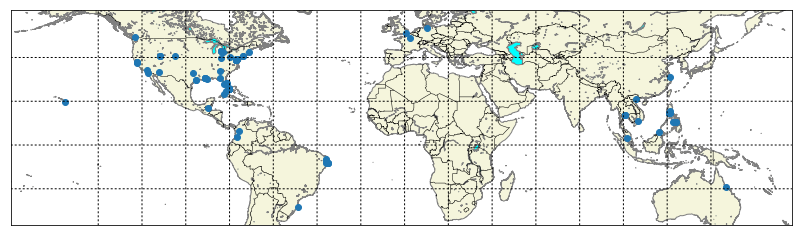

In [8]:
# first, just load up a Spotter_Plotter() class; plot data and see if everything is working properly.
#
fg = plt.figure(figsize=(14,10))
plt.clf()
ax=plt.gca()
#
zikaer = Spotter_Plotter(data_file=data_file, lon_sep=20, lat_sep=20, ax=ax)

### KMeans clustering:
- Baisc idea: given the data, choose some N centers (not yet determined); minimize the cumulative distance from each data point to one center; clusters are designed by the NN relationship between each data point and one center.
- In general, clustering is accomplished by defining a quantitative cost function that relates the data to one another -- for example, their distance to a set of utility points (centers), NN distances between points, etc.
- There are many, many ways to define clusters, and depending on the cost function being employed, many ways to sample the parameter space; the main trick is to find a cluster definition that is useful and computationally feasible.
- We use Sci-kit Learn (sklearn) clustering utilities (sklearn.clusters).
- See also the notebook:
    cluster_finder_sklearn_development_worksheet.ipynb
- In this (referenced) notebook, we show a bunch of alternative clustering models, in addition to k-means. Somewhere, we also have a pretty gnarly, highly versatile but very compute-intensive NN based clustering algorithm.

#### In the next couple of panes:
- Load up an skcp.KMeans() clustering object
- "fit" the Zika data to this class instance.
- Get the clusters and plot them on a map, so that they can be seen as clusters. Clusters are shown as nodes connected to thier center of mass (CM).
- Note: One of the disadvantages of k-means is that we have to 'know' (or a priori decide) how many clusters there will be. This is fine for some circumstances, and probably good for most binary decisions (2 clusters), but may not be best suited for more complex problems.
- We'll start with a large number of clusters -- say 8, pretty much arbitrarily.


ll_ranges:  -155.09073 146.80569 -28.4825 53.57532


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: ax

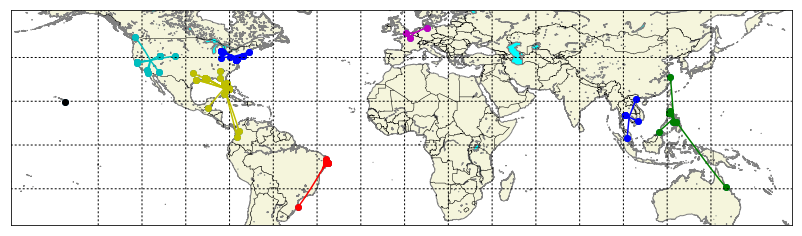

In [9]:
kmeans_3 = skcp.KMeans(n_clusters=8, random_state=0)
kmeans_3.fit_predict(numpy.array(zikaer.XY))
#
clusts = get_clusters(kmeans_3, zikaer.XY)
#
plt.figure(figsize=(14,14))
plt.clf()
ax = plt.subplot('111')
#
zikaer = Spotter_Plotter(data_file=data_file, lon_sep=20, lat_sep=20, ax=ax)
#
for j,ctr in enumerate(kmeans_3.cluster_centers_):
	clr = colors_[j%len(colors_)]
	#zikaer.cm.scatter(*ctr, marker='D', s=95, c=clr)
	zikaer.cm.scatter(*zikaer.cm(*zip(*clusts[j])), marker='o', c=clr )
	for xy in clusts[j]:
		#zikaer.cm.plot(*zikaer.cm(*zip(*[xy, ctr])), marker='.', ls='-', lw=1.5, color=clr, zorder=7)
		zikaer.cm.drawgreatcircle(*xy, *ctr, 1, color=clr)
	pass

#


#### Choosing the "right" number of clusters
- As discussed above, k-means requires that we a priori specify the number of clusters.
- In some cases, the number of clusters can be pre-defined (split a data set into 1,2,3... clusters).
- We can "eyeball" this, but is there an 'automagical' way to do this (an algorithm)?
- Sure; we can write an algorithm -- or more specifically, define a cost function and optimization routine.
- ... but there still is not any one, single, magic optimization; we have to define a partitioning algorithm.
- In practice, we would optimize this partitioning from some test data and some desired outcomes (aka, we know -- from external validation, that locations (a,b,c) contracted Zika from locations (d,e).
- In the end, the dirty secret of Data Science and Machine Learning is that algorithms are subjective; they are **not** objective or agnostic.
- Nonetheless, we'll demonstrate an optimization algorithm:
    - Basically, we want some combination of the total distance(s) and the mean distance of each data point to one cluster center, and then apply some penalty (or reward) based on the number of clusters.

In [10]:
# define a clustering score metric (procedural function), and maybe a couple of helper functions as well.
#
def cluster_kmean_score1(clusts=None, centers=None, denom_exp=.5):
	if clusts is None: return None
	if centers is None: centers = [] 
	#if not isinstance(clusts, dict): clusts = {k:cl for k,cl in enumerate(clusts.items())}
	if not isinstance(clusts, dict): clusts = {k:cl for k,cl in enumerate(clusts)}
	#
	N_total = float(sum([len(cl) for cl in clusts.items()]))    
	score = 0.
	#
	#for (cl_index, clust), ctr in zip(clusts.items(), centers):
	for clust, ctr in zip(clusts.values(), centers):
		#
		# do we want, sometimes, to override ctr, and just use the local CM? 
		#ctr = numpy.mean(clust, axis=0)
		if ctr is None: ctr = numpy.mean(clust, axis=0)
		#
		# a few variations on the score metric:
		# score += numpy.sqrt(numpy.sum([(gdp.great_circle(rw[::-1], ctr[::-1]).km**2.)
		#score += numpy.sum([euclid_dist(rw,ctr)*111.1
		score += numpy.sum([gdp.great_circle(rw[::-1], ctr[::-1]).km
									for rw in clust])/len(clust)
		#
	# note: we can use denom_exp as a tuning parameter to optimize our metric. we might do the same
	# with the len(clust) parameter as well.
	return score*(len(clusts)**denom_exp)
#
def euclid_dist(xy1, xy2):
	return numpy.sqrt( (numpy.array(xy1) - numpy.array(xy2))**2.)
#
def get_NNs_geopy(x,lon_lat):
	return min([[x,ll, geopy.distance.great_circle(x[::-1],ll[::-1]).km] for ll in lon_lat], key=lambda rw:rw[2])
#

### Optimized K-Means clustering:
- Evaluate clustering for k = 2,3,4,...,10 maybe clusters.
- Keep the clustering for k that minimizes the metric (more or less; we might still be a bit subjective).

kmscore[2]: -79530.78656704117 // 4149.11556829094
kmscore[3]: -40667.111041129305 // 10138.711235892051
kmscore[4]: -25012.82387980831 // 12672.908257701522
kmscore[5]: -13328.618135906454 // 8846.815306637014
kmscore[6]: -9797.580855335525 // 9591.810753793863
kmscore[7]: -7827.35366558086 // 9952.56555006798
kmscore[8]: -6110.822851461706 // 9777.890786811293
kmscore[9]: -4643.862021693973 // 10046.162934149093


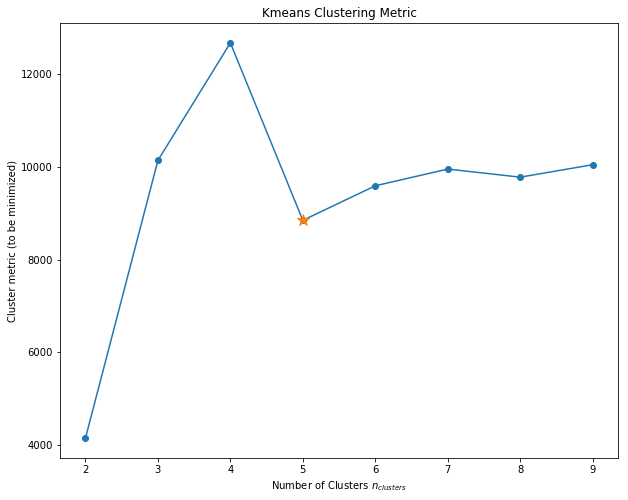

In [11]:
scores = []
for k in range(2,10):
	kmeans = skcp.KMeans(n_clusters=k, random_state=None)
	kmeans.fit(numpy.array(zikaer.XY.copy()))
	#
	clusts = get_clusters(kmeans, zikaer.XY)
	#print('** centers: ', kmeans.cluster_centers_)
	cl_score = cluster_kmean_score1(clusts=clusts, centers=kmeans.cluster_centers_)
	scores += [[k, cl_score]]
	#
	print('kmscore[{}]: {} // {}'.format(k, kmeans.score(zikaer.XY), cl_score))
# 
min_score = min(scores[1:], key=lambda rw:rw[1])
plt.figure(figsize=(10,8))
plt.clf()
ax = plt.gca()
ax.plot(*zip(*scores), ls='-', marker='o', label='scores')
ax.plot(*min_score, ls='', marker='*', ms=12, label='min(scores)')
ax.set_xlabel('Number of Clusters $n_{clusters}$')
ax.set_ylabel('Cluster metric (to be minimized)')
ax.set_title('Kmeans Clustering Metric')

#### Re-plot with optimized number of clusters
- Note, we also output the cluster index, center, and size.
- Presumably, we can consider the cluster centers "hotspots" and rank-order them by size
- Of course, this is just a starting place. We'll need to more carefully evaluate these data -- are there duplicate entries? What do we do with duplicates (arguably "re-tweets" might be more valuable)


ll_ranges:  -155.09073 146.80569 -28.4825 53.57532


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: ax

cluster[0]:: location: ([-119.42067333333333, 37.083112499999999]), size: 12
cluster[1]:: location: ([117.12552761904763, 12.285072857142859]), size: 21
cluster[2]:: location: ([-37.329165714285715, -10.626785714285724]), size: 7
cluster[3]:: location: ([-81.197801842105264, 30.046530394736841]), size: 76
cluster[4]:: location: ([4.4126333333333321, 51.191736666666671]), size: 3


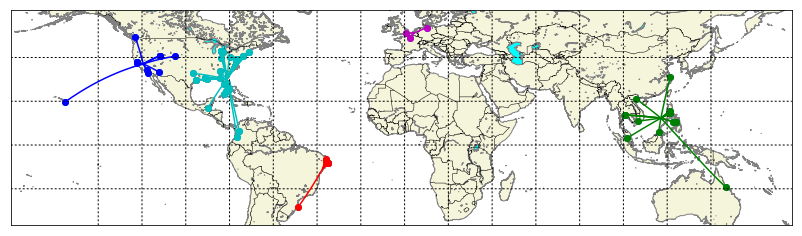

In [12]:
# now re-plot the reported locations, but with the new clustering (with optimal number of clusters -- which is
# usually around 5)
#
kmeans = skcp.KMeans(n_clusters=min_score[0], random_state=0)
kmeans.fit_predict(numpy.array(zikaer.XY))
#
clusts = get_clusters(kmeans, zikaer.XY)
#
plt.figure(figsize=(14,14))
plt.clf()
ax = plt.subplot('111')
#
zikaer = Spotter_Plotter(data_file=data_file, lon_sep=20, lat_sep=20, ax=ax)
#
for j,ctr in enumerate(kmeans.cluster_centers_):
	clr = colors_[j%len(colors_)]
	#zikaer.cm.scatter(*ctr, marker='D', s=95, c=clr)
	zikaer.cm.scatter(*zikaer.cm(*zip(*clusts[j])), marker='o', c=clr )
	for xy in clusts[j]:
		#zikaer.cm.plot(*zikaer.cm(*zip(*[xy, ctr])), marker='.', ls='-', lw=1.5, color=clr, zorder=7)
		zikaer.cm.drawgreatcircle(*xy, *ctr, 1, color=clr)
	#
	print('cluster[{}]:: location: ({}), size: {}'.format(j,list(ctr), len(clusts[j])))
#



### Now something with the text (and other) data
- The most logical thing to do would be to use the date fields to determine network directionality. Do we need a new clustering definition for this?
- Maybe a NN, sequential clustering algorithm (there are some interesting examples of this from Zaliapin et al. at UNR).


### Space-time clustering:
- If we rotate around the 3d plot (or looking at the 2d plots -- in both cases, see below, or just examining the data), we can see clearly that these data partition very cleanly in time. Of course, this will likely not be true after we expand this data set.
- What might be beneficial is do devise some sort of algorithm to regularize this matrix -- to equate the spatial dimension(s) with the temporal dimension.
- This is easy in Cosmology and relativity physics, but less obvious in contemporary science
- It might be possible to, following the Cosmological models, establish a time-space equality. In Cosmology, this is defined by the speed of light $c$, in epidemiology, this might be (similarly) the expected range of propagation, which might be estimated from a random walk or some other model (ie, how far do we expect a carrier to walk in a day?)
- We might also look at supurlative models, where we manage one of the axes using some sort of nearest-neighbors or record-breaking criteria.
- Zaliapin et al., at UN Reno have done some interesting work in this domain. We'll probably just do something simple, to demonstrate the concept.
    - Maybe a directional graph of each point and it's subsequent spatial NN (aka, nearest neighbor occurring after).
	    - This is an imperfect metric in a number of ways -- for example, it amplifies errors in reported times of incidence/observation; it can also (in other sciences) enforce poor assumptions of sequential causality (for example, the presumtion that a large event triggers a small event, or vice versa).
	- Also, there are smart and fast ways to find NNs, but we're not going to use them. We want to code this up quickly...

In [13]:
#for rw in numpy.array(list(zika_data.values())).T[0:5]:
#	print(rw)
#print('cols: ', zika_data.keys())

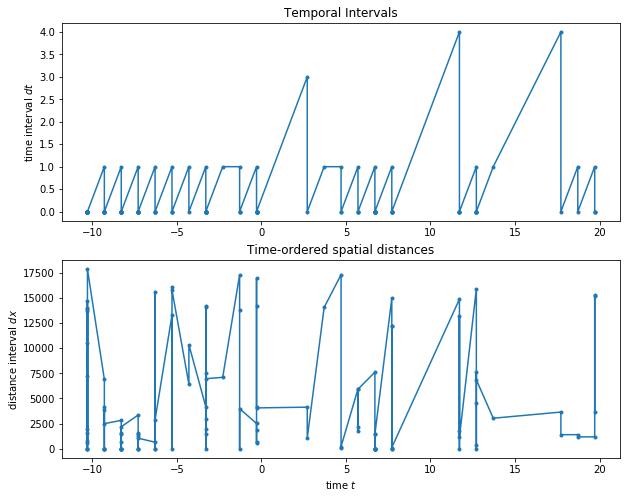

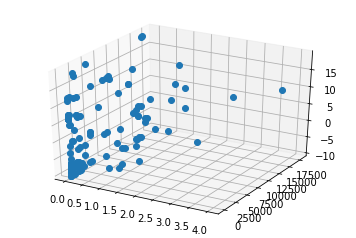

In [ ]:
# first, construct some time and space intervals; let's use a numerical "float_date" field
# for date and sequenceing 
#
zika_data['f_date'] = mpd.date2num(zika_data['date'])
#
# make a time-ordered list of the zika data, compute the space and time intervals.
# we can combine these steps, to make 1) more compact code, 2) better optimized code (fewer copies, more
#   computation in place, etc.), and probably a smaller memory footprint (see #2). but we're going to spell
#   it out, just to be demonstrative...
#
zika_intervals = zip(zika_data['f_date'], zika_data['longitude'], zika_data['latitude'])
zika_intervals = list(sorted(zika_intervals, key=lambda rw:rw[0]))
zika_intervals = list(zip(*zika_intervals))
zika_intervals += [[0.] + list(numpy.diff(zika_intervals[0]))]
zika_intervals += [[0.] + [geopy.distance.great_circle((y1,x1), (y2,x2)).km for x1,y1,x2,y2 
						  in zip(zika_intervals[1][1:], zika_intervals[2][1:], 
								 zika_intervals[1][:-1], zika_intervals[2][:-1])]]
#zika_intervals = numpy.array(zika_intervals).T
zika_intervals = numpy.core.records.fromarrays(zika_intervals, dtype = [(cl, '<f8')
                                        for cl in ['f_date', 'longitude', 'latitude', 'dt', 'dist']])
#
#print(zika_intervals[0:5])
#
X = mean_reduce(zika_intervals['f_date'])
#
plt.figure(figsize=(10,8))
plt.clf()
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax2.set_xlabel('time $t$')
ax1.set_ylabel('time interval $dt$')
ax1.set_title('Temporal Intervals')
ax2.set_ylabel('distance interval $dx$')
ax2.set_title('Time-ordered spatial distances')
#
ax1.plot(X, zika_intervals['dt'], '.-')
ax2.plot(X, zika_intervals['dist'], '.-')
#
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(zika_intervals['dt'], zika_intervals['dist'], X, 'o')




### Regular NN pairs:
- Compute regular NN pairs, then plot great circle pairs (not too surprisingly, the GS arcs are not visible at this scale; all the NN pairs are quite close together).
- ... so we want to try something a bit more interesting.

In [ ]:
# first, the complets NN pairs:
XY = numpy.array([zika_intervals['longitude'], zika_intervals['latitude']]).T

#
plt.figure(figsize=(14,14))
plt.clf()
ax = plt.subplot('111')
zikaer = Spotter_Plotter(data_file=data_file, lon_sep=20, lat_sep=20, ax=ax)
nn_pairs_complete = [get_NNs_geopy(xy, XY) for xy in XY]
#
for k, ((x1,y1),(x2,y2),z) in enumerate(nn_pairs_complete):
    #zikaer.cm.plot(*zikaer.cm(*zip(x1,x2)), 'o-')
    clr = colors_[k%len(colors_)]
    # this looks like a good idea, but we see right away that we get a  bunch of trans-global
    # circles which are super messy -- which is too bad, since the good NN GS plots look super cool.
    # we'll need to look at those more closely. later. for now, let's just draw straight lines.
    #
    #zikaer.cm.drawgreatcircle(*x1, *x2, 10)
    # TODO: make these arrows (.cm has a vectors/arrows, whatever function, i think, (x,y,dx,dy))
    #zikaer.cm.plot(*zikaer.cm(*zip(*[x1, x2])), marker='.', ls='-', lw=1.5, zorder=7)
    #dxy = numpy.array(zikaer.cm(x2)) - numpy.array(x1))
    #print('dxy: ', dxy, x1)
    #x,y = ziker.cm(x1)
    #
    x1x,y1x = zikaer.cm(x1,y1)
    x2x,y2x = zikaer.cm(x2,y2)
    #zikaer.cm.quiver(x1x,y1x, x2x-x1x, y2x-y1x, latlon=False, lw=1.5, color=clr, units='dots',
    #                 width=3, headwidth=4, headlength=5)
    #
    #ax.plot([x1x,x2x], [y1x, y2x], 'o-', color=clr)
    # (x1, y1, x2, y2, {dx_for_GS_calc})
    #
    zikaer.cm.drawgreatcircle(x1,y1, x2,y2, 10., color=clr)
    zikaer.cm.scatter((x1x,x2x), (y1x,y2x), marker='o', color=clr)
    #
    #ax.plot((x1x,x2x), (y1x,y2x), marker='', ls='-', color=clr)
    pass
#

ll_ranges:  -155.09073 146.80569 -28.4825 53.57532


### Time-ordered NN pairs:
- So, as discussed, what about a group's "next" NN? The spatial NN for a given point and all events that follow it.
- Nominally, this implies causality. We'd need a better understanding of endemic propagation rates, etc. to be conclusive, but this is (maybe) a good way to start tracking the progress of an epidemic.

In [ ]:
plt.figure(figsize=(16,10))
ax=plt.gca()
#
# TODO: modify Spotter_Plotter: move plotting routine to separate function (outside of __init__())
# so we can recycle it.
#
zikaer = Spotter_Plotter(data_file=data_file, lon_sep=20, lat_sep=20, ax=ax)
#
# get time-ordered NN pairs:
nn_pairs = [get_NNs_geopy(xy, XY[(k+1):]) for k,xy in enumerate(XY[:-1])]
#
#
for k, ((x1,y1),(x2,y2),z) in enumerate(nn_pairs):
    clr = colors_[k%len(colors_)]
    #
    x1x,y1x = zikaer.cm(x1,y1)
    x2x,y2x = zikaer.cm(x2,y2)
    #zikaer.cm.quiver(x1x,y1x, x2x-x1x, y2x-y1x, latlon=False, lw=1.5, color=clr, units='dots',
    #                 width=3, headwidth=4, headlength=5)
    # we could use this to show the (presumed) direction of propagation, but it's tricky to do this
    # in a way that is not messy.
    #ax.quiver(x1,y1, (x2-x1), (y2-y1), lw=1.)
    zikaer.cm.drawgreatcircle(x1,y1, x2,y2, 10., color=clr)

### Let's have a look at nn_pairs, specifically the nn_distance:
- just plot them
- probabiliyt curve?
- Note, we can use this as a metric to define clusters if we like, but we still need to set some sort of possibly subjective threshold to separate the clusters.
- Nominally, we can use the probability distribution (right hand pane) to help us identify cluster breaks, aka, break clusters for improbable sequential NN distances.


In [ ]:
#for k, ((x1,y1),(x2,y2),z) in enumerate(nn_pairs):
#	
plt.figure(figsize=(9,6))
plt.clf()
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
#
dists = [rw[2] for rw in nn_pairs]
#
ax2.plot(sorted(dists), numpy.linspace(0.,1., len(dists)))
#
ax1.plot(dists, ls='-', marker='.')

ax2.set_title('Cumulative Probability')
ax2.set_ylabel('$P(<x)$')
ax2.set_xlabel('dist')
ax1.set_title('distances')
ax1.set_ylabel('dist')


### Time-Forward NN Clustering:

- Can we define clusters from forward-NN?
- Let's script up a cluster finding strategey:
    - use stdev(nn_distance) as a distannce threshold standard
    - walk through nn_pairs; if the nn_distance between two pairs is larger than some threshold, start
      a new cluster.
-  then, we'll wrap it up into a class structure below.

- Note: this clustering model, i think, is a good illustration of how clustering is made, but maybe not the best clustering algorithm for our purposes (which, of course, we have not yet defined.)
- Note: Also, we get some nominally undesirable artifacts from the modulus nature of our spherial earth -- aka, translating periodic coordinates to/from rectalinear coordinates. Most particularly, consider two points at say, $lon_1 = -179^o$, $lon_2=179^o$. Their realy minimum angular separation is on order $d\_lon \approx 2^o$, and so thier GS distance is maybe $dx \approx 200~km$ near the equator, but if we don't handle our graphical representation (transformation to rectangular coordinates), as we have not done here, we might get a GS through the $d\_lon \approx 358^o$. Similarly, rather than a mean value $<lon> \approx (180^o~or~-180^o)$, we get $<lon> \approx 0^o$. These are standard concerns and challenges when working with angular coordinates.
- So in general, I think this is a good demonstration of how to construct a clustering algorithm, and this time-forward NN cluster model might be useful to show propagation vectors, but they can be pretty spatially extended, and so not terribly useful to our purposes.

### Another approach: Field-theory clustering
- Unfortunately, we're not going to get to this just yet, but...
- Instead of focusing on node-to-node edge relationships, write a field-model for each point, like 

\begin{equation}
z(r) = \frac{a}{(b + r)^q} 
\end{equation}

where $r$ is the radial distance between two points, $|x_2 - x_1|$, and $a,~b,~q$ are scaling exponents. We can then compute and aggregate the "field strength" $z$ for each data point, at each locatioin on the map. From this, we can construct a 'heat map', and we can define clusters, hot-spots, etc. from the contours. For examples of this with respect to earthquake hazard, see Yoder et al. (2015), and some derivative papers as well.

In [ ]:
# can we define clusters from this?
# let's script up a cluster finding strategey:
#    - use stdev(nn_distance) as a distannce threshold standard
#    - walk through nn_pairs; if the nn_distance between two pairs is larger than some threshold, start
#      a new cluster.
#  then, we'll wrap it up into a class structure below.
#
# note: this clustering model, i think, is a good illustration of how clustering is made, but maybe not
#       the best clustering algorithm for our purposes (which, of course, we have not yet defined.)
#
zs = [rw[-1] for rw in numpy.copy(nn_pairs)]
sigma = numpy.std(sorted(zs)[int(.2*len(zs)):int(numpy.ceil(.8*len(zs)))])
dx0 = 3.*sigma
print('dx0: {}/{} // {}'.format(dx0, sigma, numpy.median(zs)))
#
clusters = [[nn_pairs[0][0][:]]]
for k, (xy1, xy2, z) in enumerate(nn_pairs):
	if z>dx0: clusters += [[]]
	#
	clusters[-1] += [xy2]
#
plt.figure(figsize=(8,6))
plt.clf()
ax0 = plt.gca()
for j, clust in enumerate(clusters):
	# we might want to look at each cluster individually:   
	plt.figure(figsize=(4,3))
	plt.clf()
	ax1 = plt.gca()
	#    
	clr = colors_[j%len(colors_)]
	x_mean = numpy.mean(clust, axis=0)
	for ax in (ax0,ax1):
		ax.scatter(*zip(*clust), marker='o', color=clr)
		for xy in clust:
			ax.plot(*zip(xy, x_mean), ls='-', marker='', color=clr)
		ax.set_title('cluster[{}]'.format(j))
	#
#

### Time-Forward NN_clusters class
- Build a class to handle forward-NN clustering
- Input a set of coordinate data
- Find forward NNs
- We can subclass to define different distance metrics
- Usa an "N-sigma" metric to break the clusters.

In [ ]:

class Forward_NN_Clusters(list):
	def __init__(self, tXY, n_sigmas=5, sigma_hi=.9, sigma_lo=.1):
		# for now, just assume that tXY is in a format like [[t,x1, x2, ... xn], ...]
		tXY = sorted(tXY, key=lambda rw: rw[0])
		self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
		#
		self.NN_pairs = self.get_NN_pairs()
		#self.sigma_0 = self.get_sigma()
		self.clusters = self.get_clusters(NN_pairs=self.NN_pairs)
		#
		# update the class with input/local values:
		#self.__dict__.update({key:val for key,val in locals().items() if not key in ('self', '__class__')})
		#
		super(Forward_NN_Clusters, self).__init__(self.clusters)
	
	#def get_sigma(self):
		pass
	def dist(self, xy1, xy2):
		# xy1, xy2 are vectors
		# for the base class, return a Euclidian distance.
		#
		return numpy.sqrt(numpy.sum(((x2-x1)**2 for x1,x2 in zip(xy1, xy2))))
	#
	def get_clusters(self, NN_pairs=None, n_sigmas=None, sigma_hi=None, sigma_lo=None):
		# again, for now, assume NN_pairs is like [[xy1, xy2, dist], ...]
		sigma_hi = sigma_hi or self.sigma_hi
		sigma_lo = sigma_lo or self.sigma_lo
		#
		if NN_pairs is None: NN_pairs=self.NN_pairs
		n_sigmas = n_sigmas or self.n_sigmas
		#
		j0 = int(sigma_lo*len(NN_pairs))
		j1 = int(numpy.ceil(sigma_hi*len(NN_pairs)))
		#
		# get stdev of "middle" distances (exclude extrema)
		#sigma = numpy.std([rw[-1] for rw in NN_pairs])
		sigma = numpy.std(sorted([rw[-1] for rw in NN_pairs])[j0:j1])
		dx0 = sigma*n_sigmas
		#
		#print()
		clusters = [[NN_pairs[0][0]]]
		for xy1, xy2, dist in NN_pairs:
			if dist>dx0:
				# new cluster:
				clusters += [[]]
			clusters[-1] += [xy2]
			#
		#
		return clusters
	#
	#def get_NN(self, x, XY, exclude_self=True):
	def get_NN(self, x, XY):
		#return min([[x,xx, self.dist(x,xx)] for xx in XY if not (x==xx and exclude_self)], key=lambda rw:rw[2])
		return min([[x,xx, self.dist(x,xx)] for xx in XY], key=lambda rw:rw[2])
#
	def get_NN_pairs(self, XY=None):
		if XY is None: XY = self.XY
		return [self.get_NN(xy, XY[(k+1):]) for k,xy in enumerate(XY[:-1])]
	def get_mean_centered_plotting_segments(self):
		# mean-centered segment (like standard k-means plotting)
		# TODO: test this; it's coded, but not tested...
		#
		cluster_segments = []
		for clust in self.clusters:
			#cluster_segments += [[]]
			mean_xy = numpy.mean(clust, axis=0)
			cluster_segments += [[[mean_xy, xy] for xy in clust]]
			#
		return cluster_segments
	#
	def get_nn_plotting_segments(self):
		# plotting segments to join cluster elements by NN.
		# this needs a bit of work. namely, we need a good mechanism to exclude self-neighbor matching,  
		#  then how to handle single-element clusters, etc. not going to happen just yet...
		#  For now, just let this break.
		#
		cluster_segments = []
		for clust in self.clusters:
			#cluster_segments += [[]]
			#mean_xy = numpy.mean(clust, axis=0)
			cluster_segments += [[self.get_NN(xy, clust[k+1:])[0:2] for k,xy in enumerate(clust)]]
			#
		#return cluster_segments
		return None
#
	@property
	def XY(self):
		return [rw[1:] for rw in self.tXY]
#
class Forward_NN_Clusters_Geo(Forward_NN_Clusters):
	#
	# def __init__(self):
		# we almost always overload __init__(), but in this case, we don't need to... except maybe to
		# enforce some input dimensionality and other restrictions, but we'll save that for another time.
	def dist(self, xy1, xy2):
		return geopy.distance.great_circle(xy1[::-1], xy2[::-1]).km
	#
#
# zika_intervals = zip(zika_data['f_date'], zika_data['longitude'], zika_data['latitude'])
tXY = sorted(zip(zika_data['f_date'], zika_data['longitude'], zika_data['latitude']), key=lambda rw: rw[0])
#FFNC = Forward_NN_Clusters(tXY, n_sigmas=5)
FFNC = Forward_NN_Clusters_Geo(tXY, n_sigmas=5, sigma_hi=.8, sigma_lo=0.)

xyn = FFNC.get_NN_pairs()
#print(FFNC.get_NN(FFNC.XY[2], FFNC.XY))
print(FFNC.tXY[0:5])
print('len: {}'.format(len(FFNC)))
#
#print('** ', FFNC[0])
plt.figure(figsize=(14,12))
plt.clf()
ax=plt.gca()
zikaer = Spotter_Plotter(data_file=data_file, lon_sep=20, lat_sep=20, ax=ax, plot_points=False)
#
# start wrapping the mean-center plotting routine into class member functions (see commented out bits below):
for j, clust in enumerate(FFNC.get_mean_centered_plotting_segments()):
#for j, clust in enumerate(FFNC.get_nn_plotting_segments()):
	clr = colors_[j%len(colors_)]
	[zikaer.cm.drawgreatcircle(*xy1, *xy2, 10) for xy1,xy2 in clust]

# for j,clust in enumerate(FFNC):
# 	clr = colors_[j%len(colors_)]
# 	zikaer.cm.scatter(*zikaer.cm(*zip(*clust)), marker='o', color=clr)
# 	#ax.scatter(*zip(*clust), marker='o', c=clr)
# 	xy_mean = numpy.mean(clust, axis=0)
# 	for xy in clust:
# 		zikaer.cm.drawgreatcircle(*xy, *xy_mean, 5, color=clr)
# 		##zikaer.cm.plot(*zip(xy,xy_mean), latlon=True, color=clr)  
# 		pass    
# 	#print('cl: ', clust)

#### Something withthe text data?
- Maybe cross-check for entries that actually contain the word "ziak"?
- We can also check for uniqueness. How mayn unique topic/title entries do we have? What do we do with "re-tweets"?
- We probably also should have, in the first place, checked for uniqueness in our original data.

In [ ]:
# something with the text data? text fields are "title" and "topic", so i presume the idea is that we've searched
# circular publicaitons for zika-like references and then geo-located them. how did we get here?
#
n_title = 0
n_topic = 0
n_neither = 0
#
for ttl,tpc in zip(zika_data['title'], zika_data['topic']):
	if 'zika' in ttl.lower(): n_title+=1
	if 'zika' in tpc.lower(): n_topic+=1
	if not ('zika' in ttl.lower() or 'zika' in tpc.lower()):
		print('neither: {} :: {}'.format(ttl, tpc))
		n_neither+=1
#
print('"zika" in title: {}/{}\n"zika" in topic: {}/{}\n"zika" in neither: {}'.format(n_title, len(zika_data['title']),
                                                                    n_topic, len(zika_data['topic']), n_neither))

#for rw in zika_data['title']:
#    print(rw)

In [ ]:
#for tpc in zika_data['topic']:
#	print(tpc)
print(len(set([s.lower() for s in zika_data['title']])), len(zika_data['title']))
print(len(set([s.lower() for s in zika_data['topic']])), len(zika_data['topic']))
print(len(set([(s1 + s2).lower() for s1,s2 in zip(zika_data['topic'], zika_data['title'])])), len(zika_data['topic']))